## introduction
自行车共享数据集上的预测建模项目。主要目标是构建一个回归模型，该模型根据各种特征（如天气条件、温度、湿度、工作日、节假日和一天中的小时）准确预测自行车租赁计数。

从数据预处理和特征工程开始，以准备用于建模的数据。处理缺失值和不一致的数据，并从日期时间列中提取星期几和小时等新功能。分类变量是独热编码的，使其适用于机器学习算法。然后使用 StandardScaler 对数值特征进行缩放，以确保所有特征具有相似的比例，这可以提高回归模型的性能。

探索性数据分析Exploratory data analysis （EDA） 以可视化各种变量的分布并了解要素与租赁计数之间的关系。从 EDA 获得的见解指导了数据预处理和特征工程步骤，以确保以最佳方式表示建模数据。

该笔记本进一步评估了几种回归算法，包括线性回归、决策树回归和随机森林回归，使用以均方根对数误差 （RMSLE） 作为评估指标的交叉验证。根据其 RMSLE 分数选择性能最佳的模型，并用于预测测试数据集的租赁计数。

总之，这本笔记本提供了对自行车租赁模式的全面分析，并为准确预测未来的租赁需求提供了一个强大的回归模型。数据预处理、特征工程和模型评估的结合确保最终预测模型非常适合对自行车租赁计数进行准确可靠的预测。

## 数据描述
为本次比赛提供的数据集包括跨越两年的每小时租赁数据。比赛的目标是仅使用租赁期之前可用的信息来预测测试集每小时租用的自行车总数。

数据集分为训练集和测试集。训练集包括每月前 19 天的数据，而测试集包括从第 20 天到每个月月底的数据。该部门允许参与者在历史数据上训练他们的模型，并评估他们在看不见的未来数据上的表现。

In [1]:
# Import necessary libraries
import pandas as pd  # Import pandas library for data manipulation and analysis
import numpy as np  # Import numpy library for numerical operations and arrays
import seaborn as sns  # Import seaborn library for data visualization
import matplotlib.pyplot as plt  # Import matplotlib.pyplot module for creating plots and visualizations
from sklearn.model_selection import train_test_split, cross_val_score  # Import functions for data splitting and cross-validation
from sklearn.preprocessing import StandardScaler  # Import StandardScaler class for feature standardization
from sklearn.linear_model import LinearRegression  # Import LinearRegression class for linear regression
from sklearn.tree import DecisionTreeRegressor  # Import DecisionTreeRegressor class for decision tree regression
from sklearn.ensemble import RandomForestRegressor  # Import RandomForestRegressor class for random forest regression
from sklearn.metrics import mean_squared_log_error, make_scorer  # Import functions for evaluation metrics

d:\work\miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Import pandas library, read the CSV file, and parse the 'datetime' column as dates.
data = pd.read_csv('./data/train.csv', parse_dates=['datetime'])
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
# Import pandas library, read the CSV file, and parse the 'datetime' column as dates for test data.
test = pd.read_csv('./data/test.csv', parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [4]:
# Check for missing values in the 'data' DataFrame using the 'isnull().sum()' method.
# This will display the count of missing values for each column in the dataset.
print(data.isnull().sum())

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


代码用于检查第 1 天到第 19 天的“日期时间”列中是否有任何缺失的小时数，这些小时表示训练数据范围。“date_range”函数在“日期时间”列中生成从最小到最大日期时间的每小时时间戳范围。“missing_hours”变量包含生成的日期范围与“数据”数据帧中现有“日期时间”值之间的差异。通过识别缺失的小时数，代码可以确保训练数据涵盖每个月前 19 天的所有小时数。

In [5]:
# Create a date range from the minimum to the maximum datetime in the 'datetime' column of the 'data' DataFrame.
# The frequency is set to hourly ('H').
date_range = pd.date_range(start=data['datetime'].min(), end=data['datetime'].max(), freq='H')

# Find the missing hours by comparing the date range with the 'datetime' column of the 'data' DataFrame.
missing_hours = date_range.difference(data['datetime'])

# Create a list of days to remove, which are days 20 to 31 (inclusive).
days_to_remove = list(range(20, 32))

# Filter out the missing hours that belong to the days in the 'days_to_remove' list.
filtered_index = missing_hours[~missing_hours.day.isin(days_to_remove)]

# Print the filtered index, which contains the missing hours for days 1 to 19.
filtered_index

DatetimeIndex(['2011-01-02 05:00:00', '2011-01-03 02:00:00',
               '2011-01-03 03:00:00', '2011-01-04 03:00:00',
               '2011-01-05 03:00:00', '2011-01-06 03:00:00',
               '2011-01-07 03:00:00', '2011-01-11 03:00:00',
               '2011-01-11 04:00:00', '2011-01-12 03:00:00',
               '2011-01-12 04:00:00', '2011-01-14 04:00:00',
               '2011-01-18 00:00:00', '2011-01-18 01:00:00',
               '2011-01-18 02:00:00', '2011-01-18 03:00:00',
               '2011-01-18 04:00:00', '2011-01-18 05:00:00',
               '2011-01-18 06:00:00', '2011-01-18 07:00:00',
               '2011-01-18 08:00:00', '2011-01-18 09:00:00',
               '2011-01-18 10:00:00', '2011-01-18 11:00:00',
               '2011-01-19 03:00:00', '2011-02-01 04:00:00',
               '2011-02-03 04:00:00', '2011-02-04 04:00:00',
               '2011-02-09 04:00:00', '2011-02-10 03:00:00',
               '2011-02-11 03:00:00', '2011-02-11 04:00:00',
               '2011-02-

该代码计算“filtered_index”系列中的小时数值计数，其中包含第 1 天到第 19 天的缺失小时数。进行分析是为了检查丢失的小时数是否意外发生，或者丢失的数据背后是否存在模式。解释显示，午夜后错过的时间更常见，这是有道理的，因为它表示没有自行车租赁的时间，导致数据丢失。

In [6]:
# Calculate the value counts of hours in the 'filtered_index' Series and normalize the results.
# Then, filter the value counts using a lambda function to only include hours with a relative frequency greater than 0.02 (2%).
filtered_hours_frequency = filtered_index.hour.value_counts(normalize=True).loc[lambda x: x > 0.02]

# The result will be the hours with a relative frequency greater than 2%, indicating the hours with relatively more missing data.
filtered_hours_frequency

3    0.396552
4    0.241379
2    0.137931
5    0.068966
1    0.034483
dtype: float64

提供的代码使用“filtered_index”中的“日期时间”值创建新的数据帧“new_data”，其中包含第 1 天到第 19 天的缺失小时数。然后，它将“new_data”与原始“数据”数据帧连接起来，创建“updated_data”并添加缺失的小时数。“updated_data”数据帧按“日期时间”列升序排序，索引根据新的排序顺序重置。注释指示填补缺失小时数的决定，确保数据集中第 1 天到第 19 天的完整且连续的小时时间序列。

In [7]:
# Create a new DataFrame 'new_data' with the 'datetime' values from 'filtered_index'.
new_data = pd.DataFrame({'datetime': filtered_index})

# Concatenate the 'new_data' DataFrame with the original 'data' DataFrame to create 'updated_data'.
# The 'ignore_index=True' parameter ensures the index is renumbered after concatenation.
updated_data = pd.concat([data, new_data], ignore_index=True)

# Sort the 'updated_data' DataFrame by the 'datetime' column in ascending order.
updated_data = updated_data.sort_values('datetime')

# Reset the index of the 'updated_data' DataFrame based on the new sort order.
updated_data = updated_data.reset_index(drop=True)

# Display the 'updated_data' DataFrame with the missing hours for days 1 to 19 added.
updated_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1.0,0.0,0.0,1.0,9.84,14.395,81.0,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10939,2012-12-19 19:00:00,4.0,0.0,1.0,1.0,15.58,19.695,50.0,26.0027,7.0,329.0,336.0
10940,2012-12-19 20:00:00,4.0,0.0,1.0,1.0,14.76,17.425,57.0,15.0013,10.0,231.0,241.0
10941,2012-12-19 21:00:00,4.0,0.0,1.0,1.0,13.94,15.910,61.0,15.0013,4.0,164.0,168.0
10942,2012-12-19 22:00:00,4.0,0.0,1.0,1.0,13.94,17.425,61.0,6.0032,12.0,117.0,129.0


分析数据后发现，“风速”列中出现了 0 值，这在现实中不太可能发生。 怀疑这些 0 值是被意外填充或作为缺失值。 相关代码旨在识别这些 0 值的分布中的任何模式，以确定它们是否具有任何有意义的意义。

绘制“风速”值为 0 时的月份和星期几的分布图后，很明显没有可辨别的模式。 因此，可以合理地得出结论，应从数据集中删除这些 0 值，因为它们不能准确表示有效的风速数据。

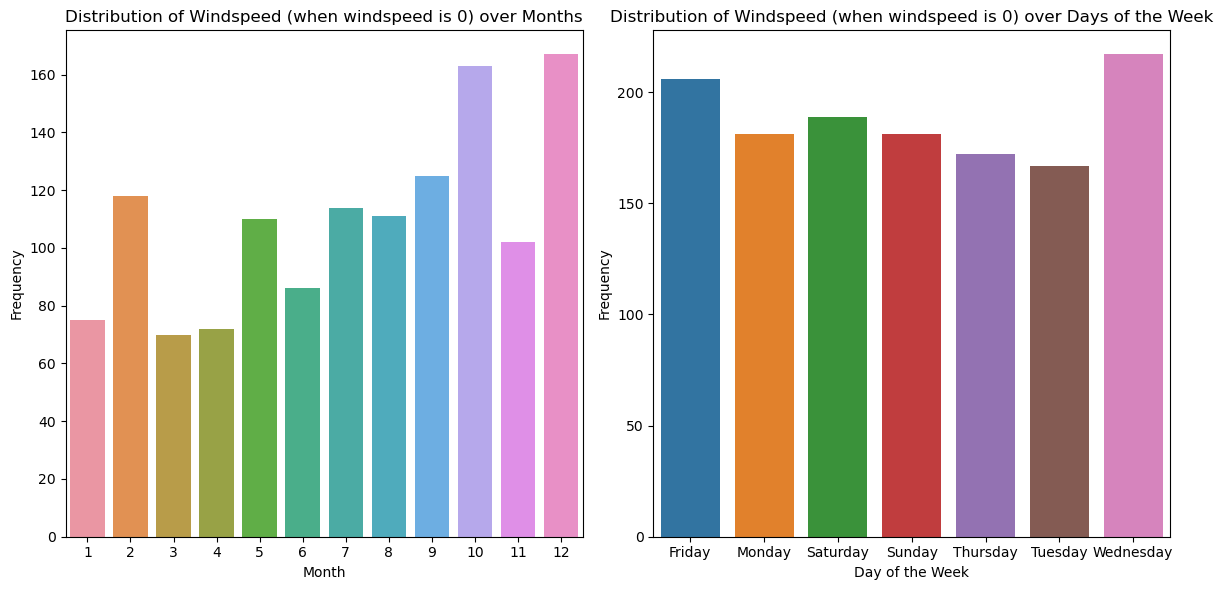

In [8]:
# Filter the 'data' DataFrame where 'windspeed' is equal to 0, and make a copy of the extracted data.
windspeed_zero_data = data[data['windspeed'] == 0].copy()

# Extract the month from the 'datetime' column and store it in a new column 'month'.
windspeed_zero_data['month'] = windspeed_zero_data['datetime'].dt.month

# Extract the day name from the 'datetime' column and store it in a new column 'day_name'.
windspeed_zero_data['day_name'] = windspeed_zero_data['datetime'].dt.day_name()

# Group the 'windspeed_zero_data' DataFrame by month and calculate the count of occurrences when 'windspeed' is 0 for each month.
windspeed_zero_count_by_month = windspeed_zero_data.groupby('month')['windspeed'].count()

# Group the 'windspeed_zero_data' DataFrame by day name and calculate the count of occurrences when 'windspeed' is 0 for each day of the week.
windspeed_zero_count_by_day = windspeed_zero_data.groupby('day_name')['windspeed'].count()

# Plot the distribution of 'windspeed' values when it's 0 over months and days of the week using two side-by-side bar plots.
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=windspeed_zero_count_by_month.index, y=windspeed_zero_count_by_month.values)
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Distribution of Windspeed (when windspeed is 0) over Months')

plt.subplot(1, 2, 2)
sns.barplot(x=windspeed_zero_count_by_day.index, y=windspeed_zero_count_by_day.values)
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.title('Distribution of Windspeed (when windspeed is 0) over Days of the Week')

plt.tight_layout()
plt.show()

在提供的代码中，“windspeed”和“humidity”列中的 0 值被视为缺失数据并替换为 NaN 值。 这是因为这些列中的 0 值可能不是有效的测量值，并且更有可能丢失数据点。 通过将 0 值转换为 NaN，我们表明这些值丢失或未知，这样可以在数据分析和建模期间更好地处理丢失的数据。 将 0 值视为 NaN 还可以确保它们不会无意中用于计算，从而防止结果出现潜在偏差和不准确。

In [9]:
# Replace values less than 1 in the 'humidity' column with NaN (Not a Number).
updated_data.loc[updated_data['humidity'] < 1, 'humidity'] = np.nan

# Replace values less than 1 in the 'windspeed' column with NaN (Not a Number).
updated_data.loc[updated_data['windspeed'] < 1, 'windspeed'] = np.nan

# Check for missing values in the 'updated_data' DataFrame using the 'isnull().sum()' method.
# This will display the count of missing values for each column in the dataset.
print(updated_data.isnull().sum())

datetime         0
season          58
holiday         58
workingday      58
weather         58
temp            58
atemp           58
humidity        80
windspeed     1371
casual          58
registered      58
count           58
dtype: int64


提供的代码用 0 填充“count”、“casual”和“registered”列中的任何缺失值。注释表明做出此决定是因为在这些缺失时间内没有发生租赁，考虑到数据集的性质以及这些特定时间没有记录的事实，这是合理的假设。 填充过程完成后，代码会检查“updated_data”DataFrame 中的缺失值，以确认这些列中不再有缺失值。

In [10]:
# Fill any missing values in the 'count' column with 0.
updated_data['count'] = updated_data['count'].fillna(0)

# Fill any missing values in the 'casual' column with 0.
updated_data['casual'] = updated_data['casual'].fillna(0)

# Fill any missing values in the 'registered' column with 0.
updated_data['registered'] = updated_data['registered'].fillna(0)

# Check for missing values in the 'updated_data' DataFrame after filling with 0.
# This will display the count of missing values for each column in the dataset.
print(updated_data.isnull().sum())

datetime         0
season          58
holiday         58
workingday      58
weather         58
temp            58
atemp           58
humidity        80
windspeed     1371
casual           0
registered       0
count            0
dtype: int64


给定代码背后的概念是使用每天的平均值来估算“风速”和“湿度”列中的缺失值。 通过根据“日期时间”列的日期部分对数据进行分组，代码计算每天的平均“风速”和“湿度”。 然后，它用相应日期的平均值填充这些列中的缺失值。

这种方法有助于保留“风速”和“湿度”随时间变化的总体趋势和变化，同时为缺失值提供合理的估计。 它确保估算值与数据集中观察到的总体模式一致，并避免在数据中引入重大偏差或失真。

这一发现凸显了关于“湿度”列中缺失值的有趣观察。 尽管努力使用每天的平均值来填充缺失值，但“湿度”列中仍然有 24 个缺失值。 发生这种情况是因为丢失了一整天的湿度数据。 因此，该特定日期没有可用的有效数据点来计算平均值，导致该天的所有 24 小时内持续存在缺失值。

当尝试估算特定日期的缺失值时，这种情况会带来挑战，因为没有相关数据可供参考。 因此，可能需要进一步调查或替代插补策略才能有效解决此特定场景中的缺失值。

In [11]:
# Fill NaN values in the 'humidity' column with the mean value of the 'humidity' for the same day.
updated_data['humidity'] = updated_data.groupby(updated_data['datetime'].dt.date)['humidity'].transform(lambda x: x.fillna(x.mean()))

# Fill NaN values in the 'windspeed' column with the mean value of the 'windspeed' for the same day.
updated_data['windspeed'] = updated_data.groupby(updated_data['datetime'].dt.date)['windspeed'].transform(lambda x: x.fillna(x.mean()))

# Check for missing values in the 'updated_data' DataFrame after filling with the mean of each day.
# This will display the count of missing values for each column in the dataset.
print(updated_data.isnull().sum())

datetime       0
season        58
holiday       58
workingday    58
weather       58
temp          58
atemp         58
humidity      24
windspeed      0
casual         0
registered     0
count          0
dtype: int64


应用前向填充后，代码会打印“updated_data”DataFrame 的每列中剩余缺失值的计数。 结果将显示执行前向填充操作后是否仍有缺失值。 此方法可用于确保在进一步分析或建模之前适当地解决和处理任何缺失值。

在这种情况下，前向填充方法是合适的，因为列（季节、假期、工作日、天气）中的缺失值可以用与下一个非缺失值相同的信息合理地填充。 这是因为这些列中的信息通常在短时间内保持不变，例如提供的数据集中的每小时间隔。

在“temp”和“atemp”列中，温度值可能每小时都会波动。 使用前向填充将缺失值替换为下一个可用温度可能无法提供特定小时的准确温度值。 它假设连续观测之间的温度保持恒定，这可能并不总是反映一小时内的实际温度变化。 因此，前向填充方法可能无法准确捕捉随时间变化的真实温度趋势。

In [12]:
# Forward fill (ffill) NaN values in each column of the 'updated_data' DataFrame.
# This fills NaN values with the last known non-NaN value in each column.
for col in updated_data.columns:
    updated_data[col] = updated_data[col].fillna(method='ffill')

# Check for missing values in the 'updated_data' DataFrame after forward filling.
# This will display the count of missing values for each column in the dataset.
print(updated_data.isnull().sum())

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


在“天气”列中，有一个实例的值被记录为“雪”。 考虑到该数据集的上下文，该值可能是异常值或错误记录的条目。 为了确保一致性并适应大多数天气条件，值“雪”更改为“雨”。 此修改有助于保持数据的一致性，并确保“天气”列准确地代表大多数情况下的主要天气状况。

In [13]:
# Calculate the counts of unique values in the 'weather' column of the 'updated_data' DataFrame.
updated_data['weather'].value_counts()

1.0    7216
2.0    2846
3.0     881
4.0       1
Name: weather, dtype: int64

In [14]:
# Replace the value 4 in the 'weather' column with the value 3 in the 'updated_data' DataFrame.
updated_data.loc[updated_data['weather'] == 4, 'weather'] = 3

In [15]:
# Replace the numeric codes in the 'season' column with corresponding string labels.
updated_data['season'].replace({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}, inplace=True)

# Replace the numeric codes in the 'weather' column with corresponding string labels.
updated_data['weather'].replace({1: 'Clear', 2: 'Mist', 3: 'Rain'}, inplace=True)

In [16]:
# Summary statistics of numerical columns
updated_data[['temp', 'atemp', 'humidity', 'windspeed', 'casual','registered', 'count']].describe()

,temp,atemp,humidity,windspeed,casual,registered,count
count,10944.000000,10944.000000,10944.000000,10944.000000,10944.000000,10944.000000,10944.000000
mean,20.176765,23.593269,62.093305,14.195270,35.831049,154.727796,190.558845
std,7.815372,8.505394,19.090631,6.796602,49.896499,151.061059,181.198471
min,0.820000,0.760000,8.000000,6.003200,0.000000,0.000000,0.000000
25%,13.940000,16.665000,47.000000,8.998100,4.000000,35.000000,41.000000
50%,20.500000,24.240000,62.000000,12.998000,16.000000,117.000000,144.000000
75%,26.240000,31.060000,78.000000,18.087160,48.000000,222.000000,283.000000
max,41.000000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [17]:
# Summary statistics of categorical columns.
updated_data[['season', 'holiday', 'workingday', 'weather']].astype('object').describe()

,season,holiday,workingday,weather
count,10944,10944.0,10944.0,10944
unique,4,2.0,2.0,3
top,Spring,0.0,1.0,Clear
freq,2736,10620.0,7452.0,7216


## Exploratory Data Analysis (EDA)
### Rental counts distribution

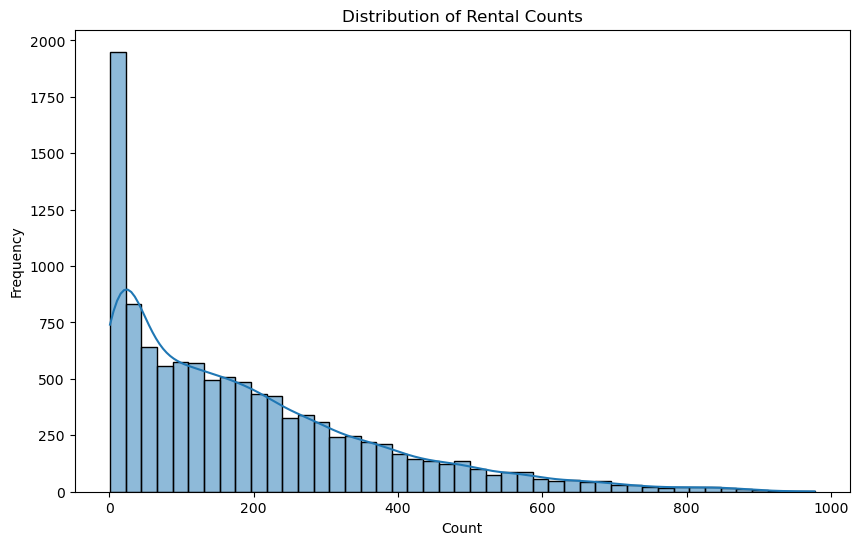

In [18]:
# Plot the distribution of the target variable 'count'
plt.figure(figsize=(10, 6))
sns.histplot(data['count'], kde=True)  # Use kde=True to display the kernel density estimate
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Distribution of Rental Counts')
plt.show()

### Correlation matrix heatmap

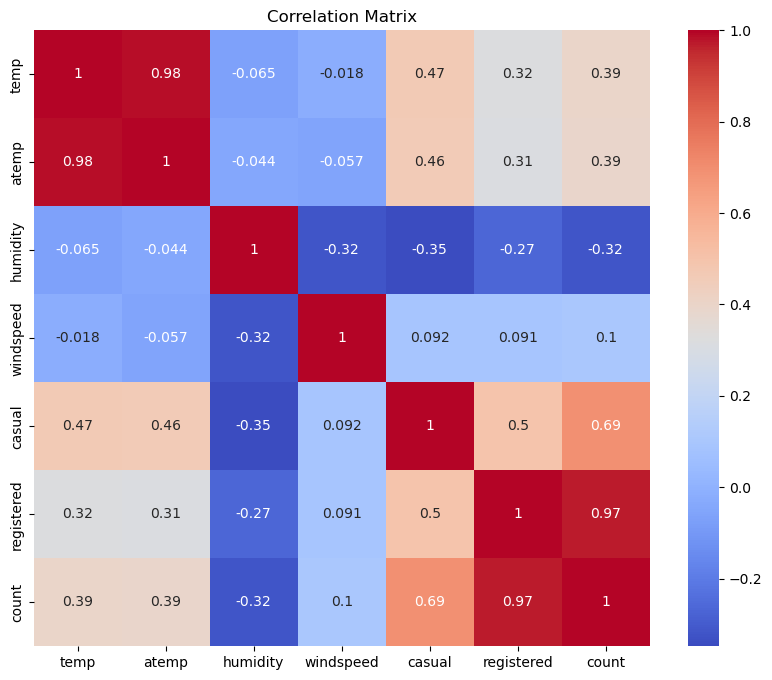

In [19]:
# Calculate the correlation matrix for the selected numerical features in the 'data' DataFrame.
correlation_matrix = data[['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [20]:
# Add a new column 'day_of_week' to the 'updated_data' DataFrame containing the day of the week (e.g., Monday, Tuesday).
updated_data['day_of_week'] = updated_data['datetime'].dt.day_name()

# Add a new column 'hour' to the 'updated_data' DataFrame containing the hour of each entry in the 'datetime' column.
updated_data['hour'] = updated_data['datetime'].dt.hour

通过将“hour”和“day_of_week”列添加到“updated_data”数据框中，我们的目标是探索这些时间特征与租赁计数之间的潜在相关性。 “小时”列代表“日期时间”列中每个条目的小时数，使我们能够分析一天中某些时段的租金计数是否较高或较低。 同样，“day_of_week”列指示每个条目是一周中的哪一天，使我们能够调查某些日子的租金计数是否具有不同的模式。

通过研究这些关系，我们可以深入了解自行车租赁的任何基于时间的趋势。 例如，我们可能会发现一周中的某些日子或特定时间对自行车租赁的需求较高。 这些信息对于规划库存管理、营销策略或优化服务以满足特定时间段内的客户需求可能非常有价值。

### Hourly rental counts distribution

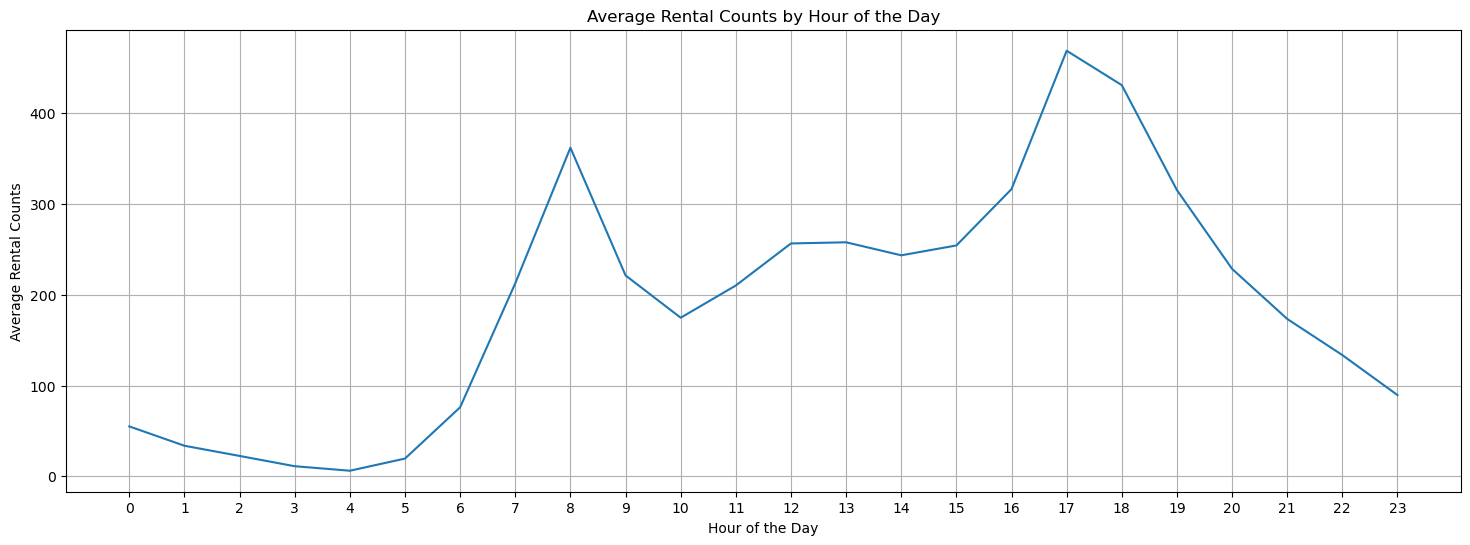

In [21]:
# Calculate the average rental counts by hour of the day
hourly_counts = updated_data.groupby('hour')['count'].mean().reset_index()

# Create a line plot to visualize the average rental counts by hour
plt.figure(figsize=(18, 6))
sns.lineplot(x='hour', y='count', data=hourly_counts)
plt.xlabel('Hour of the Day')
plt.ylabel('Average Rental Counts')
plt.title('Average Rental Counts by Hour of the Day')
plt.xticks(ticks=range(24), labels=range(24))
plt.grid()
plt.show()

帽子的观察是相当合理的。 从小时租赁数量分布来看，早晚工作时间存在高峰，表明这段时间自行车租赁需求较高。 这种模式与人们可以使用自行车进行日常通勤的想法是一致的。

早高峰可能代表人们骑自行车去工作场所，而晚高峰可能代表他们回家的路。 在工作时间，人们更有可能通勤，与一天中的其他时间相比，对自行车租赁的需求似乎更高。

此外，非工作时间（例如清晨和深夜）的租赁量较少，这一事实支持了自行车在高峰工作时间主要用于通勤目的的观点。

总体而言，每小时租赁计数分布为了解自行车租赁的使用模式提供了宝贵的见解，并强调了自行车使用与工作相关的通勤活动之间的潜在相关性。

我们将每天检查租赁数量，以确定整周自行车使用的任何模式或变化。 通过使用可视化技术比较每天的平均租赁数量，我们的目的是了解是否存在特定日期自行车租赁量显着较高或较低的情况。 该分析将帮助我们深入了解自行车租赁行为每天的变化，例如工作日通勤或周末休闲目的的使用率更高。 最终，我们的目标是根据一周中的某一天发现用户中任何显着的趋势或偏好。

### Daily rental counts patterns

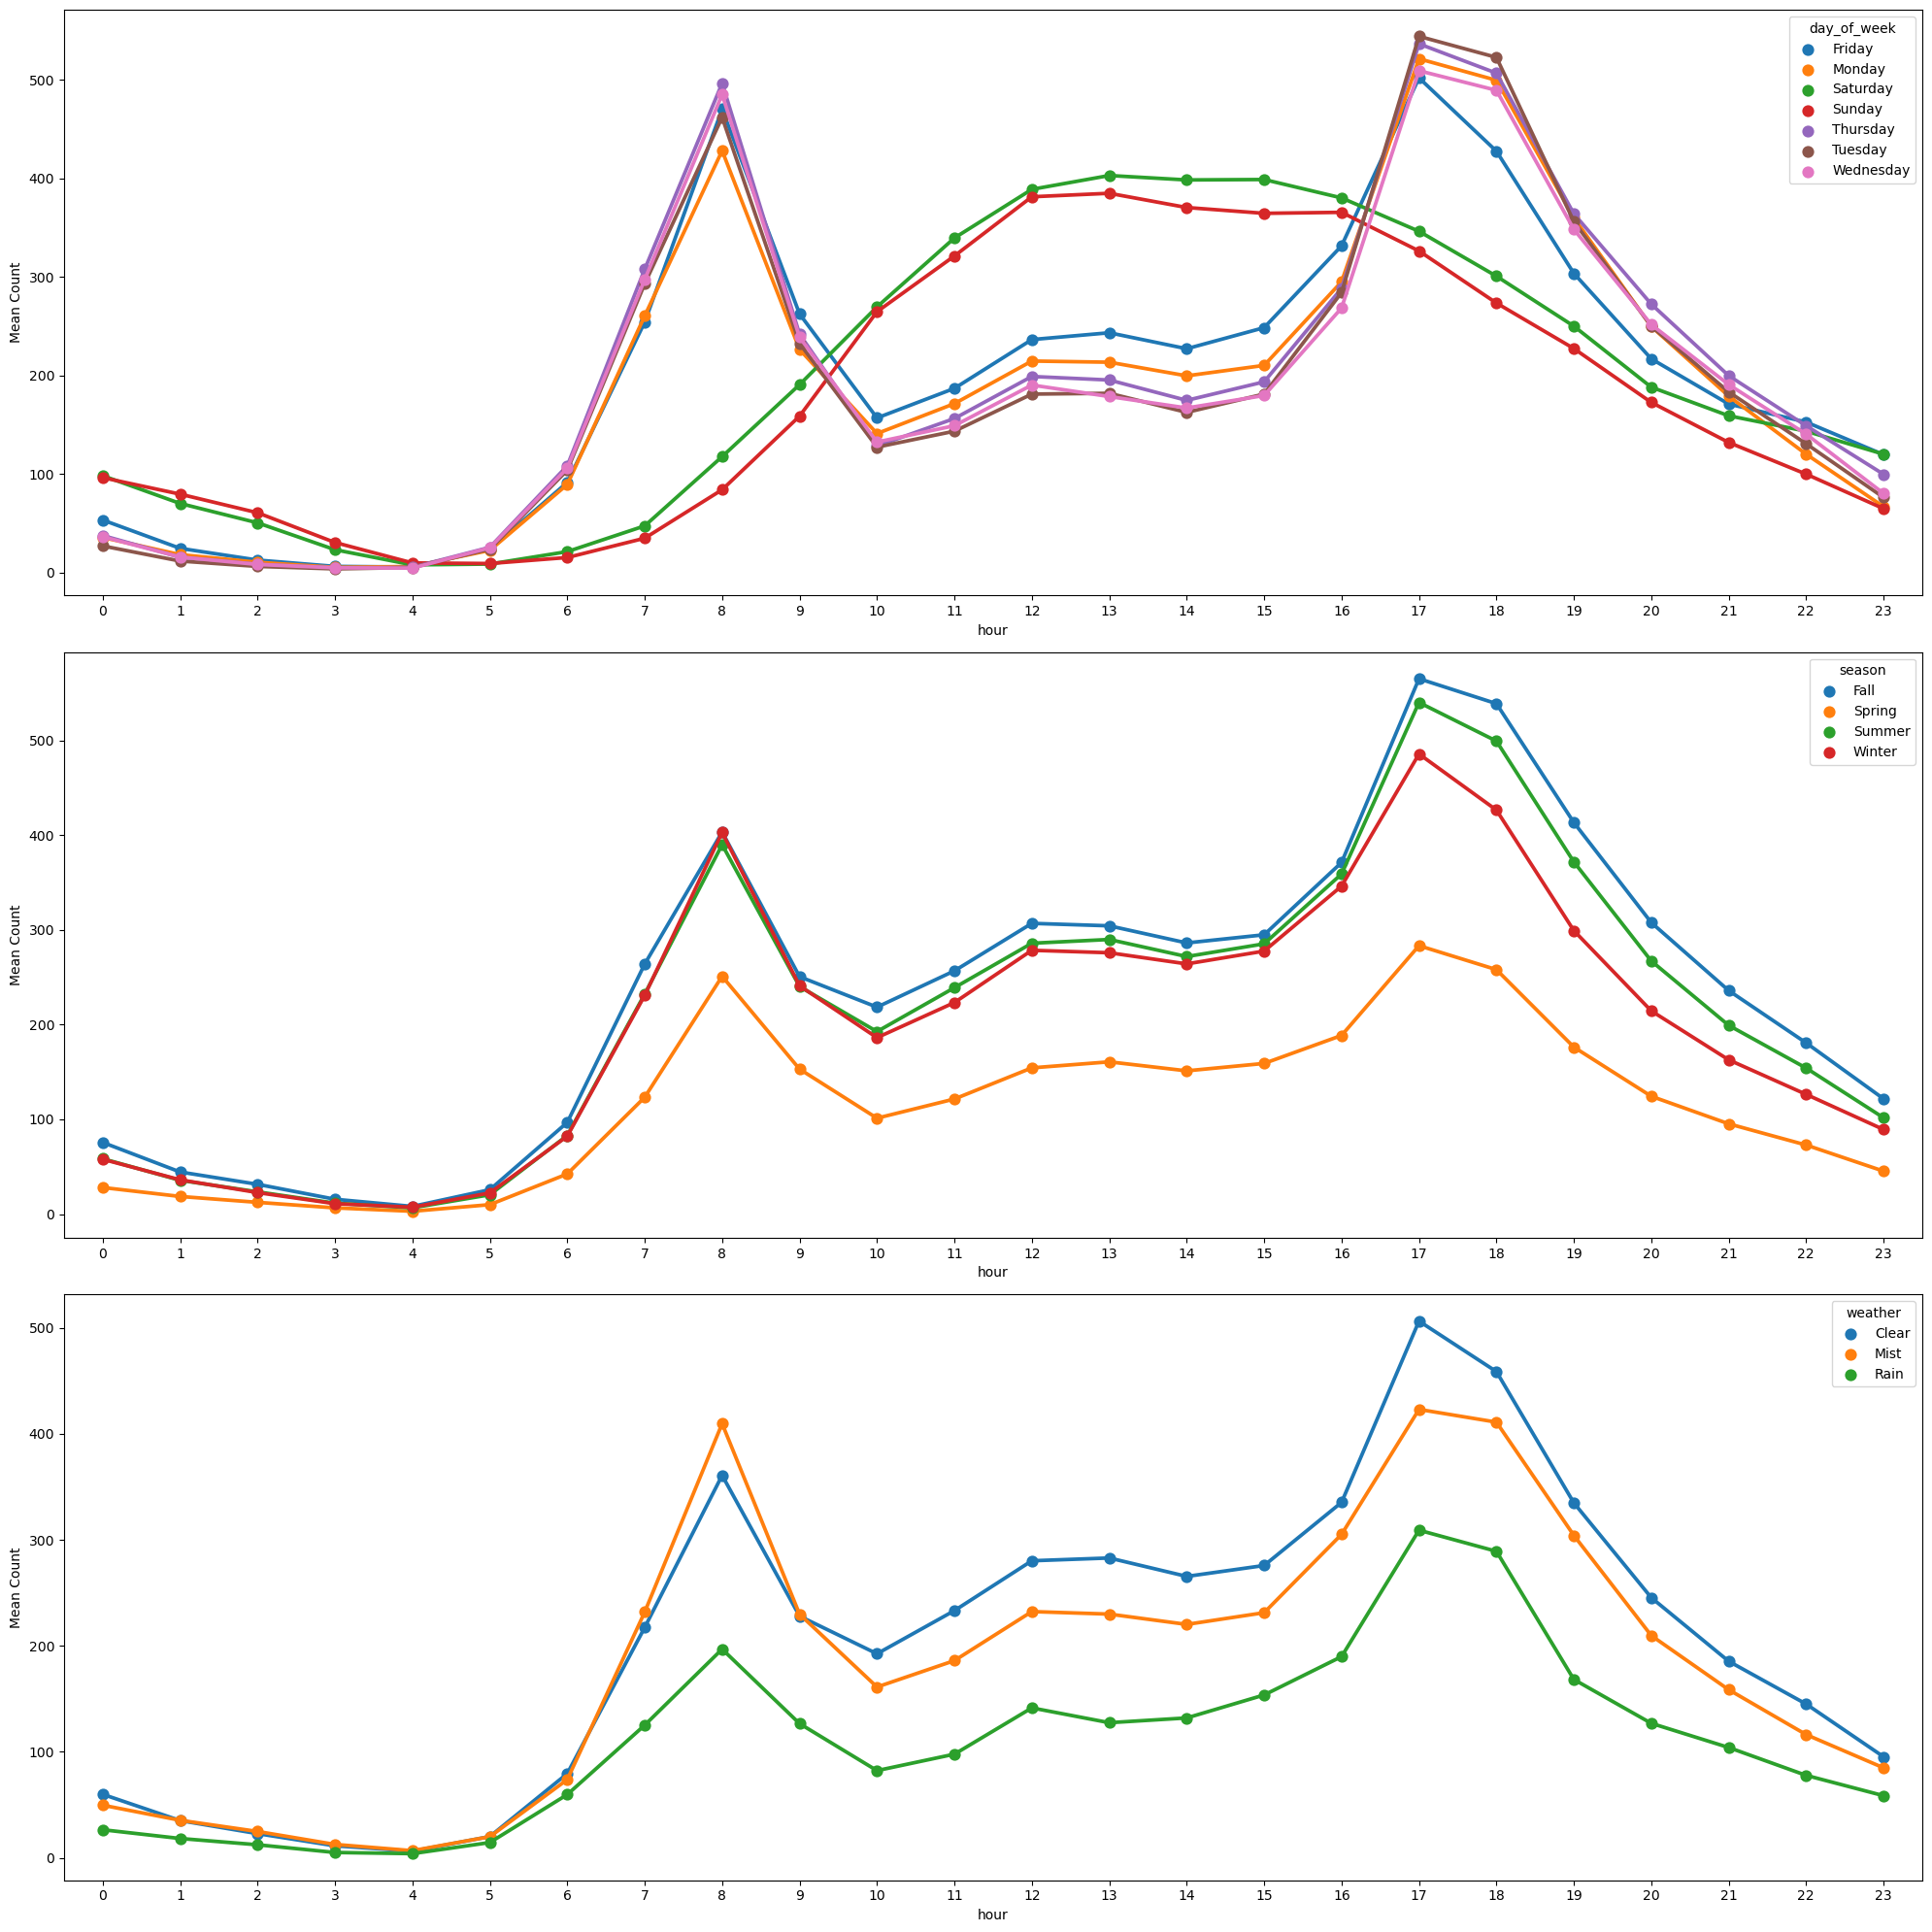

In [22]:
# Create a 3x1 grid of subplots with a shared x-axis and a size of 20x20 inches
fig, ax = plt.subplots(3, 1, figsize=(20, 20))

# Plot the mean rental counts per hour based on day of the week
hour_day_df = updated_data.groupby(["hour", "day_of_week"])["count"].mean().to_frame().reset_index()
ax1 = sns.pointplot(x=hour_day_df["hour"], y=hour_day_df["count"], hue=hour_day_df["day_of_week"], ax=ax[0])
ax1.set_ylabel("Mean Count")

# Plot the mean rental counts per hour based on season
hour_season_df = updated_data.groupby(["hour", "season"])["count"].mean().to_frame().reset_index()
ax2 = sns.pointplot(x=hour_season_df["hour"], y=hour_season_df["count"], hue=hour_season_df["season"], ax=ax[1])
ax2.set_ylabel("Mean Count")

# Plot the mean rental counts per hour based on weather conditions
hour_weather_df = updated_data.groupby(["hour", "weather"])["count"].mean().to_frame().reset_index()
ax3 = sns.pointplot(x=hour_weather_df["hour"], y=hour_weather_df["count"], hue=hour_weather_df["weather"], ax=ax[2])
ax3.set_ylabel("Mean Count")

# Adjust the layout to avoid overlapping of subplots
plt.tight_layout()

# Show the plot
plt.show()

星期几图表揭示了自行车租赁数量的不同模式。 在工作日（周一至周五），租赁数量呈现出类似的趋势，工作时间内的使用量较高，这与我们之前的观察结果一致。 然而，在周末（周六和周日），租赁数量显示出不同的模式，下午的使用量较高。 这种变化凸显了一周中的某一天对自行车租赁行为的影响的重要性。 分析表明，工作日的特点是通勤使用量增加，而周末则在下午时间休闲使用量增加。 了解这些模式可以为根据特定的高需求日期和时间优化自行车共享服务和资源分配提供宝贵的见解。

图表分析证实了周末（周六和周日）的明显趋势，除了最后三个小时外，全天的租金数量保持一致。 很明显，与其他日子相比，周六的租金数量最高，特别是在最后一小时。 这种行为背后的原因是周五和周六都是周末，让人们有机会在外面呆到很晚，从而影响深夜的租金计数。 另一方面，工作日需要早起，导致深夜的租金数量减少。 这一观察结果强调了一周中的某一天对租赁模式的影响，对于制定在特定时间和日期优化自行车共享服务的策略非常有价值。

### Average rental counts by season

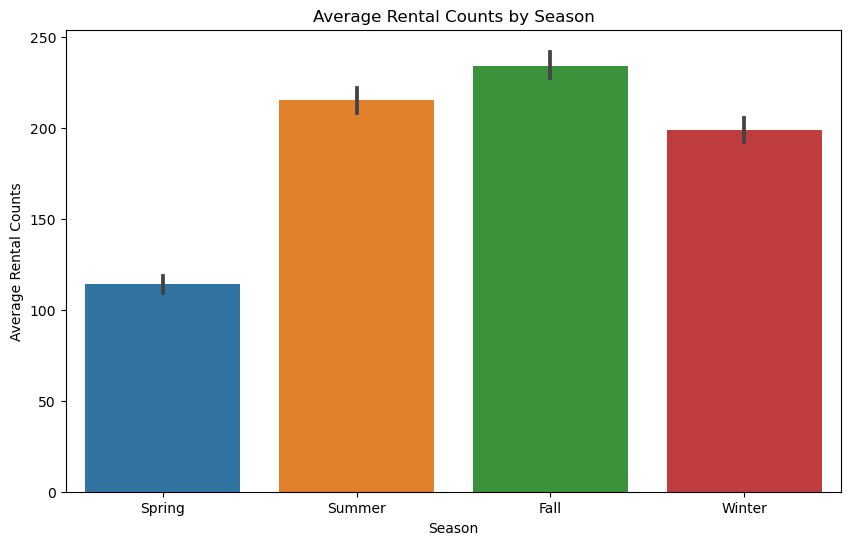

In [23]:
# Plot the average rental counts by season
plt.figure(figsize=(10, 6))
sns.barplot(x='season', y='count', data=updated_data)
plt.xlabel('Season')
plt.ylabel('Average Rental Counts')
plt.title('Average Rental Counts by Season')
plt.show()

### Average rental counts by weather

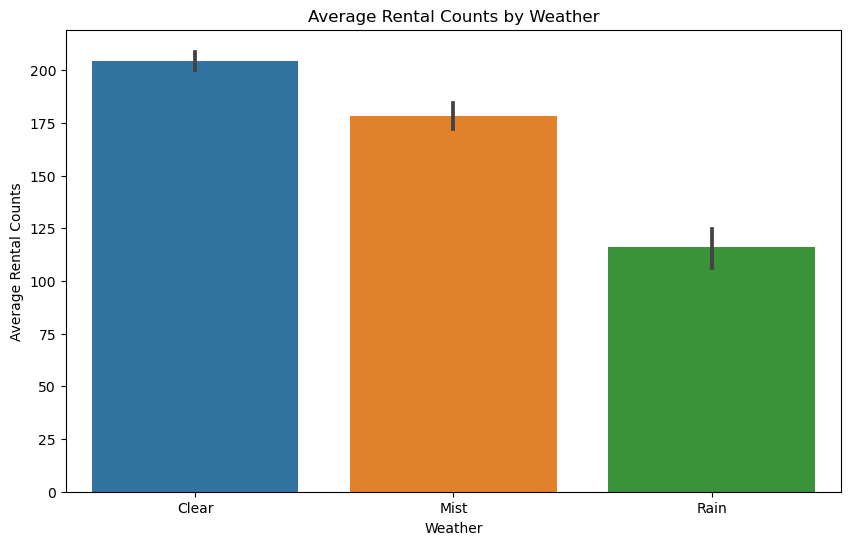

In [24]:
# Plot the average rental counts by weather conditions
plt.figure(figsize=(10, 6))
sns.barplot(x='weather', y='count', data=updated_data)
plt.xlabel('Weather')
plt.ylabel('Average Rental Counts')
plt.title('Average Rental Counts by Weather')
plt.show()

### Rental counts by working day/holiday/weekend

In [25]:
# Group the 'updated_data' DataFrame by the 'workingday' column and calculate various statistics for the 'count' column
updated_data.groupby('workingday')['count'].agg(['sum','count','mean','std'])

,sum,count,mean,std
workingday,,,,
0.0,654872.0,3492,187.534937,173.800744
1.0,1430604.0,7452,191.975845,184.557417


In [26]:
# Group the 'updated_data' DataFrame by the 'holiday' column and calculate various statistics for the 'count' column
updated_data.groupby('holiday')['count'].agg(['sum','count','mean','std'])

,sum,count,mean,std
holiday,,,,
0.0,2027668.0,10620,190.929190,181.555874
1.0,57808.0,324,178.419753,168.878168


In [27]:
# Calculate rental count statistics for holiday scenario
holiday_stats = updated_data[updated_data['holiday'] == 1]['count'].agg(['sum', 'count', 'mean', 'std'])

# Calculate rental count statistics for weekend scenario (non-holiday and non-working day)
weekends = updated_data[(updated_data['holiday'] == 0) & (updated_data['workingday'] == 0)]['count'].agg(['sum', 'count', 'mean', 'std'])

# Calculate rental count statistics for working day scenario
workingdays = updated_data[updated_data['workingday'] == 1]['count'].agg(['sum', 'count', 'mean', 'std'])

# Create a DataFrame to display the rental count statistics for different scenarios
statistics = pd.DataFrame({
    'scenario': ['Holiday', 'Weekend', 'Working day'],
    'count': [holiday_stats.loc['count'], weekends.loc['count'], workingdays.loc['count']],
    'mean': [holiday_stats.loc['mean'], weekends.loc['mean'], workingdays.loc['mean']],
    'standard deviation': [holiday_stats.loc['std'], weekends.loc['std'], workingdays.loc['std']],
    'sum': [holiday_stats.loc['sum'], weekends.loc['sum'], workingdays.loc['sum']]
})

# Display the rental count statistics
print(statistics)

      scenario   count        mean  standard deviation        sum
0      Holiday   324.0  178.419753          168.878168    57808.0
1      Weekend  3168.0  188.467172          174.295464   597064.0
2  Working day  7452.0  191.975845          184.557417  1430604.0


该表表明，与节假日相比，人们倾向于在周末（周六和周日）租用更多自行车。 这一观察结果表明，在人们有更多空闲时间的周末，共享单车服务更适合休闲活动和娱乐目的。 在假期，自行车租赁需求似乎相对较低，可能是由于其他与假期相关的活动或通勤需求减少。

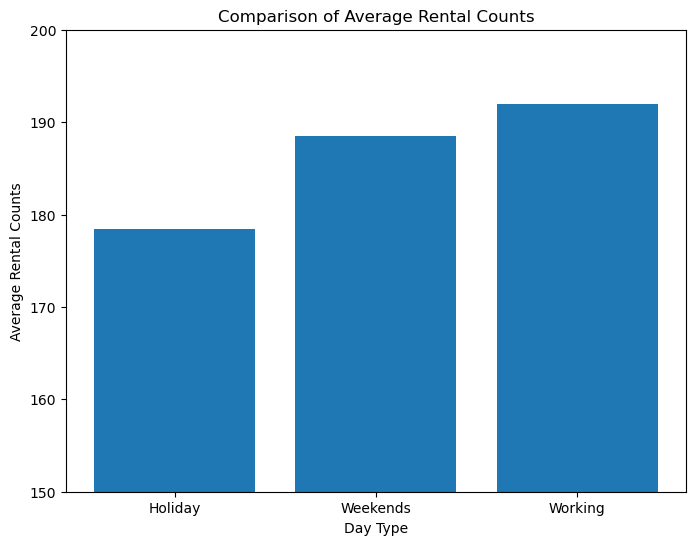

In [28]:
# Calculate average rental counts for holiday and weekends
holiday_counts = updated_data[updated_data['holiday'] == 1]['count'].mean()
weekends = updated_data[(updated_data['holiday'] == 0) & (updated_data['workingday'] == 0)]['count'].mean()
workingday = updated_data[updated_data['workingday'] == 1]['count'].mean()

# Plot the average rental counts
plt.figure(figsize=(8, 6))

# Bar positions
positions = [0, 1, 2]
labels = ['Holiday', 'Weekends', 'Working']

# Bar heights
heights = [holiday_counts, weekends, workingday]

# Plotting the bars
plt.bar(positions, heights)

# Adding labels and title
plt.xlabel('Day Type')
plt.ylabel('Average Rental Counts')
plt.title('Comparison of Average Rental Counts')

# Adding custom x-axis labels
plt.xticks(positions, labels)

# Setting a specific range for the y-axis (ylim)
plt.ylim(150, 200)

# Displaying the plot
plt.show()

### humidity and windspeed distribution

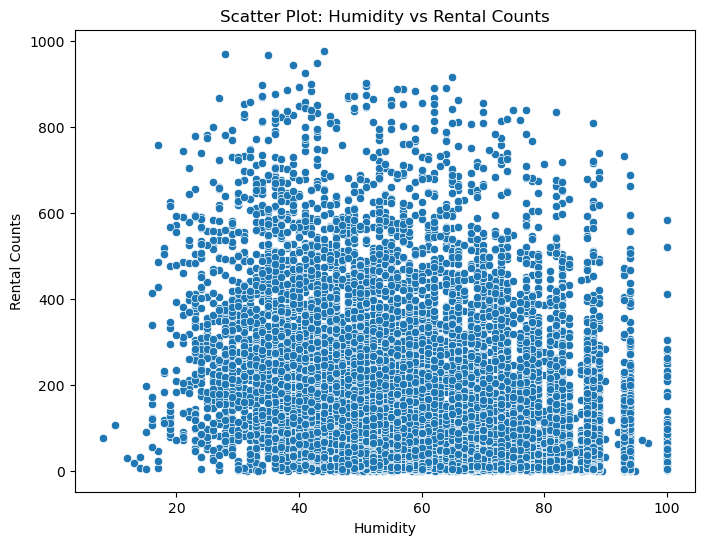

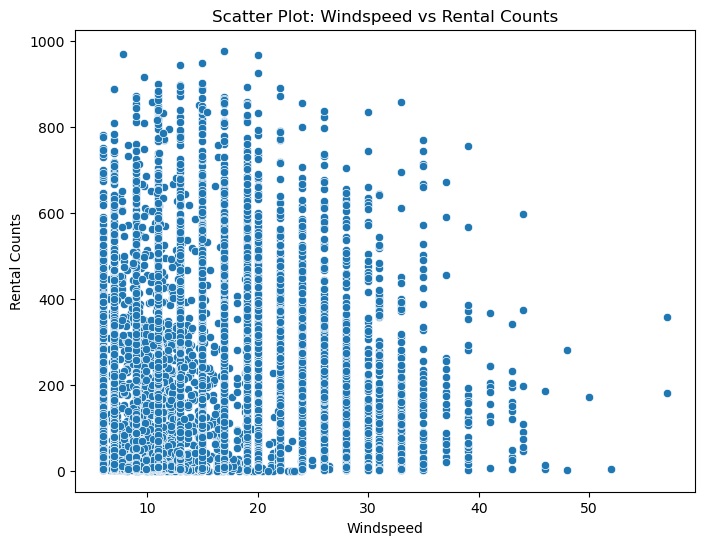

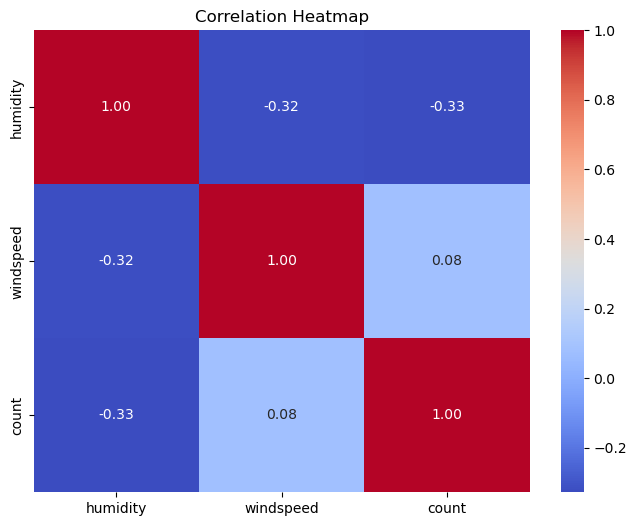

In [29]:
# Scatter plot for humidity vs rental counts
plt.figure(figsize=(8, 6))
sns.scatterplot(x='humidity', y='count', data=updated_data)
plt.xlabel('Humidity')
plt.ylabel('Rental Counts')
plt.title('Scatter Plot: Humidity vs Rental Counts')
plt.show()

# Scatter plot for windspeed vs rental counts
plt.figure(figsize=(8, 6))
sns.scatterplot(x='windspeed', y='count', data=updated_data)
plt.xlabel('Windspeed')
plt.ylabel('Rental Counts')
plt.title('Scatter Plot: Windspeed vs Rental Counts')
plt.show()

# Correlation analysis
correlation_matrix = updated_data[['humidity', 'windspeed', 'count']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

散点图表明风速和租赁数量之间没有明显的相关性。 数据点分散，没有任何明显的模式，表明风速的变化对自行车租赁的需求没有显着影响。

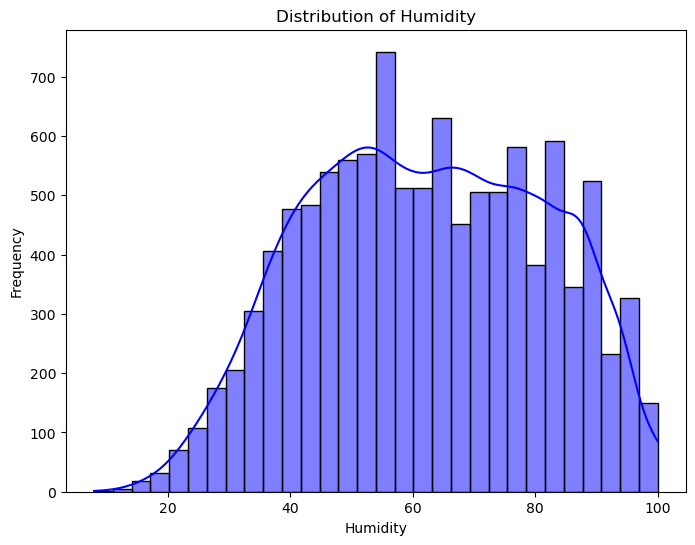

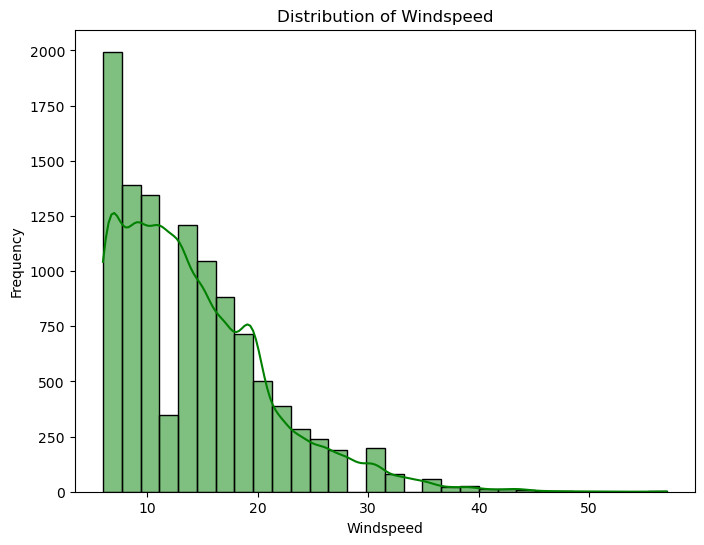

In [30]:
# Plot histogram for 'humidity'
plt.figure(figsize=(8, 6))
sns.histplot(updated_data['humidity'], kde=True, color='blue', bins=30)
plt.xlabel('Humidity')
plt.ylabel('Frequency')
plt.title('Distribution of Humidity')
plt.show()

# Plot histogram for 'windspeed'
plt.figure(figsize=(8, 6))
sns.histplot(updated_data['windspeed'], kde=True, color='green', bins=30)
plt.xlabel('Windspeed')
plt.ylabel('Frequency')
plt.title('Distribution of Windspeed')
plt.show()

### Casual and Registered Users Analysis

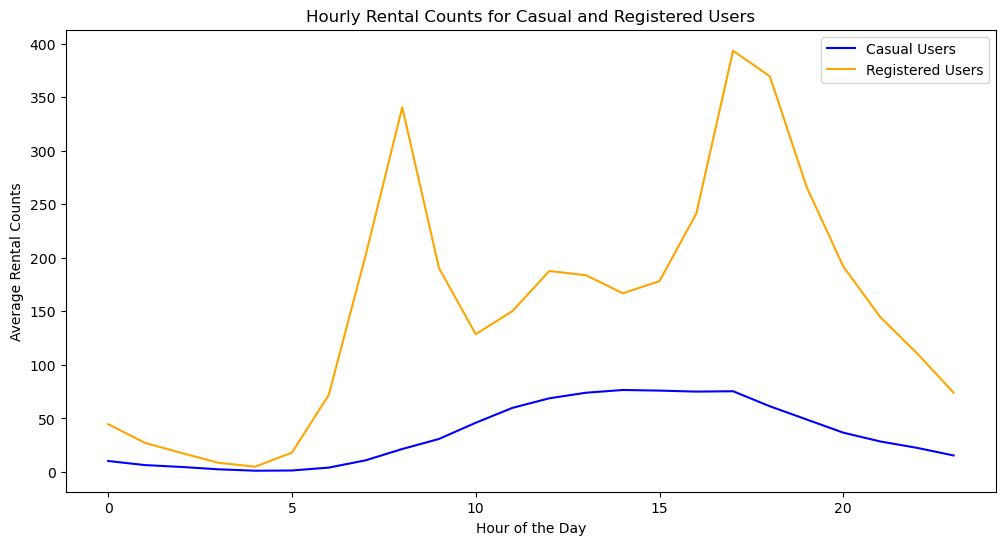

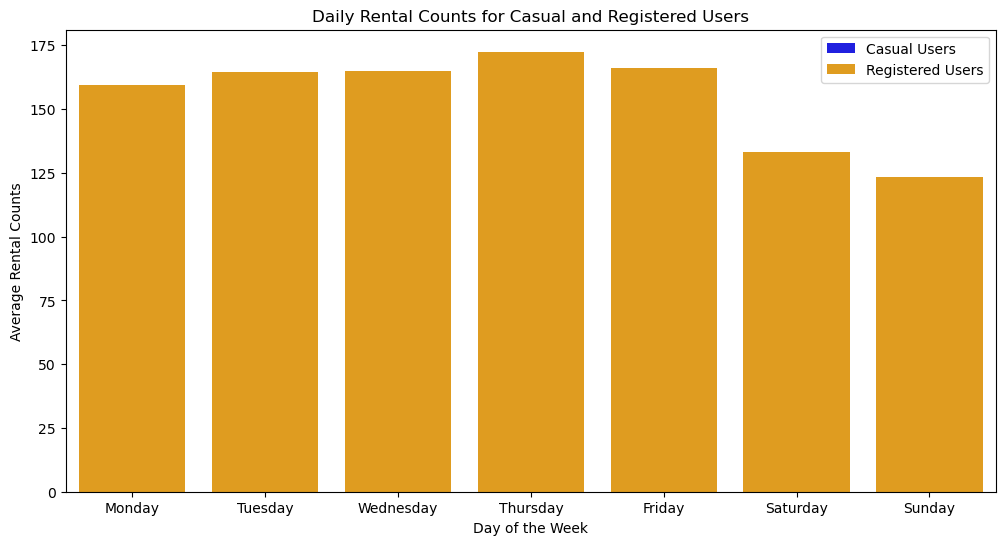

In [31]:
# Group data by 'hour' and calculate the mean rental counts for casual and registered users
hourly_counts_casual = updated_data.groupby('hour')['casual'].mean()
hourly_counts_registered = updated_data.groupby('hour')['registered'].mean()

# Plot hourly rental counts for casual and registered users
plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_counts_casual.index, y=hourly_counts_casual.values, label='Casual Users', color='blue')
sns.lineplot(x=hourly_counts_registered.index, y=hourly_counts_registered.values, label='Registered Users', color='orange')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Rental Counts')
plt.title('Hourly Rental Counts for Casual and Registered Users')
plt.legend()
plt.show()

# Group data by 'day_of_week' and calculate the mean rental counts for casual and registered users
day_of_week_counts = updated_data.groupby('day_of_week')[['casual', 'registered']].mean()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot daily rental counts for casual and registered users side by side
plt.figure(figsize=(12, 6))
sns.barplot(x=day_of_week_counts.index, y=day_of_week_counts['casual'], label='Casual Users', color='blue', order=day_order)
sns.barplot(x=day_of_week_counts.index, y=day_of_week_counts['registered'], label='Registered Users', color='orange', order=day_order)
plt.xlabel('Day of the Week')
plt.ylabel('Average Rental Counts')
plt.title('Daily Rental Counts for Casual and Registered Users')
plt.legend()
plt.show()

分析显示，可能在日常通勤中使用自行车的注册用户表现出与工作时间类似的模式。 另一方面，休闲用户则有不同的趋势，下午的租赁数量更高。 这一观察结果表明，注册用户主要使用自行车来满足日常工作需求，而休闲用户则倾向于在休闲时间更多地租用自行车。

第二张图表显示，注册用户倾向于在工作日更频繁地租赁自行车，而在周末则表现出相对较低的租赁活动。 相比之下，与工作日相比，休闲用户在周末更频繁地租用自行车。 这一发现表明，注册用户在工作周期间主要使用自行车进行日常通勤，而休闲用户则更多地将其用于周末的娱乐目的。

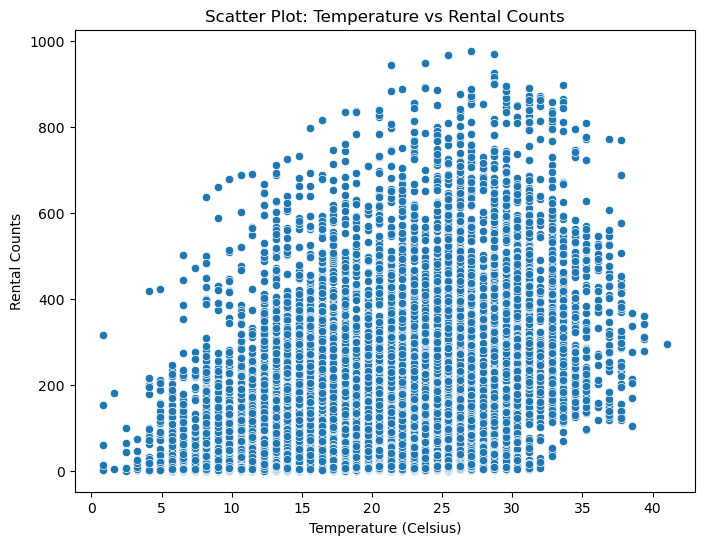

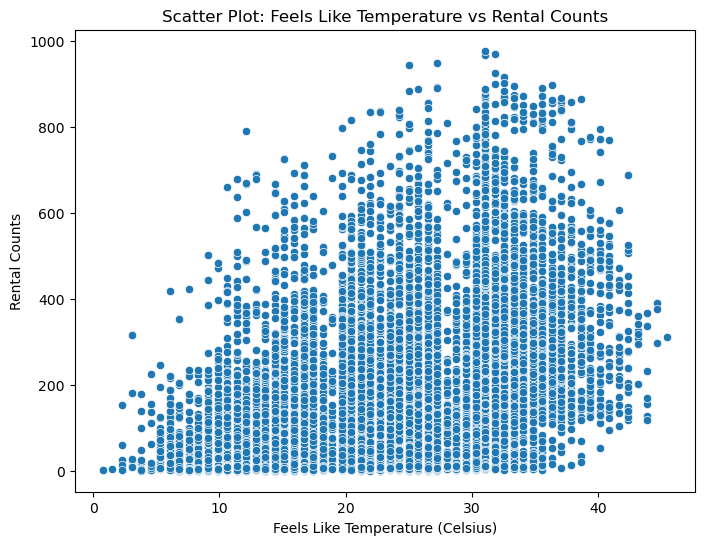

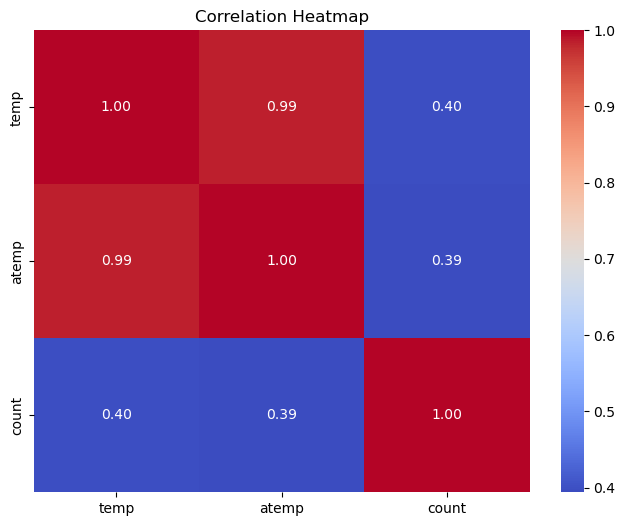

In [32]:
# Scatter plot for 'temp' vs rental counts
plt.figure(figsize=(8, 6))
sns.scatterplot(x='temp', y='count', data=updated_data)
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Rental Counts')
plt.title('Scatter Plot: Temperature vs Rental Counts')
plt.show()

# Scatter plot for 'atemp' vs rental counts
plt.figure(figsize=(8, 6))
sns.scatterplot(x='atemp', y='count', data=updated_data)
plt.xlabel('Feels Like Temperature (Celsius)')
plt.ylabel('Rental Counts')
plt.title('Scatter Plot: Feels Like Temperature vs Rental Counts')
plt.show()

# Correlation analysis
correlation_matrix = updated_data[['temp', 'atemp', 'count']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

该图表显示“temp”和“atemp”列之间存在很强的相关性，表明这两个特征包含高度冗余的信息。 因此，这些列之一可以被认为是多余的或不需要进一步分析，因为它提供与另一列基本相同的信息。

## Data Preprocessing
### Removing irrelevant columns

In [33]:
# Drop unnecessary columns from the updated_data DataFrame
updated_data.drop(['datetime', 'atemp', 'windspeed', 'casual', 'registered'], axis=1, inplace=True)

### One-hot encoding categorical features

In [34]:
# List of columns to encode using one-hot encoding
columns_to_encode = ['season', 'weather', 'day_of_week']

# Perform one-hot encoding on the specified columns
updated_data = pd.get_dummies(updated_data, columns=columns_to_encode)

# Display the first few rows of the updated DataFrame
updated_data.head()

,holiday,workingday,temp,humidity,count,hour,season_Fall,season_Spring,season_Summer,season_Winter,weather_Clear,weather_Mist,weather_Rain,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,0.0,0.0,9.84,81.0,16.0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0
1,0.0,0.0,9.02,80.0,40.0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0
2,0.0,0.0,9.02,80.0,32.0,2,0,1,0,0,1,0,0,0,0,1,0,0,0,0
3,0.0,0.0,9.84,75.0,13.0,3,0,1,0,0,1,0,0,0,0,1,0,0,0,0
4,0.0,0.0,9.84,75.0,1.0,4,0,1,0,0,1,0,0,0,0,1,0,0,0,0


### Scaling numerical features

In [35]:
# List of columns to scale
columns_to_scale = ['temp', 'humidity', 'hour']

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the StandardScaler on the selected columns to calculate mean and standard deviation
scaler.fit(updated_data[columns_to_scale])

# Transform the selected columns using the calculated mean and standard deviation
updated_data[columns_to_scale] = scaler.transform(updated_data[columns_to_scale])

# Display the first few rows of the updated DataFrame after scaling
updated_data.head()

,holiday,workingday,temp,humidity,count,hour,season_Fall,season_Spring,season_Summer,season_Winter,weather_Clear,weather_Mist,weather_Rain,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,0.0,0.0,-1.322680,0.990410,16.0,-1.661325,0,1,0,0,1,0,0,0,0,1,0,0,0,0
1,0.0,0.0,-1.427606,0.938026,40.0,-1.516862,0,1,0,0,1,0,0,0,0,1,0,0,0,0
2,0.0,0.0,-1.427606,0.938026,32.0,-1.372399,0,1,0,0,1,0,0,0,0,1,0,0,0,0
3,0.0,0.0,-1.322680,0.676106,13.0,-1.227936,0,1,0,0,1,0,0,0,0,1,0,0,0,0
4,0.0,0.0,-1.322680,0.676106,1.0,-1.083473,0,1,0,0,1,0,0,0,0,1,0,0,0,0


在此步骤中，“拟合”方法应用于训练数据，以计算用于缩放的特征的平均值和标准差。 然后，使用“变换”方法将计算出的缩放参数应用于测试数据，确保测试数据以与训练数据相同的方式进行变换。 此过程确保训练数据集和测试数据集之间特征缩放的一致性。

In [36]:
# Split the DataFrame into features (X) and target variable (y)
X = updated_data.drop('count', axis=1)
y = updated_data['count']

### Train-test split for model evaluation

In [37]:
# Split the data into training and testing sets
# with 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Print the shapes of the training and testing sets
print("Training set - X shape:", X_train.shape)
print("Testing set - X shape:", X_test.shape)
print("Training set - y shape:", y_train.shape)
print("Testing set - y shape:", y_test.shape)

Training set - X shape: (8755, 19)
Testing set - X shape: (2189, 19)
Training set - y shape: (8755,)
Testing set - y shape: (2189,)


## Modeling
### RMSLE Evaluation

In [52]:
# Define the Root Mean Squared Logarithmic Error (RMSLE) scorer
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, np.clip(y_pred, 0, None)))

# Make the RMSLE scorer
rmsle_scorer = make_scorer(rmsle)

均方根对数误差 (RMSLE) 评分器用于评估模型的性能。 RMSLE 是回归任务中常用的衡量预测准确性的指标。 它对目标变量的低估和高估进行惩罚，使其适合自行车租赁数量预测任务。 RMSLE 值越低，模型的预测与实际目标值越吻合。

### Cross-validation results

In [39]:
# Initialize and evaluate different regression models using cross-validation
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}

for model_name, model in models.items():
    # Perform cross-validation with RMSLE scorer
    cv_scores = cross_val_score(model, X_train, y_train, scoring=rmsle_scorer, cv=5)
    
    print(f"Model: {model_name}")
    print(f"Cross-Validation RMSLE: {cv_scores}")
    print(f"Average RMSLE: {np.mean(cv_scores)}\n")

Model: Linear Regression
Cross-Validation RMSLE: [1.25228238 1.25974527 1.37370923 1.24459725 1.27481495]
Average RMSLE: 1.2810298138406275

Model: Decision Tree
Cross-Validation RMSLE: [0.57375441 0.54943219 0.54767776 0.5757902  0.55304964]
Average RMSLE: 0.55994084382829

Model: Random Forest
Cross-Validation RMSLE: [0.45796575 0.41803947 0.41364159 0.45336272 0.44721849]
Average RMSLE: 0.43804560489066435



在评估多个回归模型后，我们发现随机森林算法在 RMSLE 指标的基础上表现出最佳性能。 因此，我们选择随机森林模型来对我们的测试数据进行预测。 随后，我们将训练好的模型应用到测试文件中，生成测试集中相应时间的租赁计数预测。

In [40]:
# Fit and evaluate the best model on the test set
best_model = RandomForestRegressor()  # Replace with the best performing model from cross-validation
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
test_rmsle = rmsle(y_test, y_pred)
print(f"Test RMSLE for the best model: {test_rmsle}")

Test RMSLE for the best model: 0.44384348765511733


## Predictions and Submission

In [41]:
# Display a concise summary of the data information in the 'test' DataFrame, including column names, data types, and non-null counts.
# Useful for quickly inspecting the dataset's structure and identifying any missing values or data issues.
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


In [42]:
# This summary provides a quick overview of the distribution and central tendencies of the numerical data in the DataFrame.
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


In [43]:
# Replace the values in the 'weather' column where the value is 4 with the value 3.
test.loc[test['weather'] == 4, 'weather'] = 3

# Replace the numeric values in the 'season' column with corresponding string labels.
test['season'].replace({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}, inplace=True)

# Replace the numeric values in the 'weather' column with corresponding string labels.
test['weather'].replace({1: 'Clear', 2: 'Mist', 3: 'Rain'}, inplace=True)

In [44]:
# Extract the day of the week and hour information from the 'datetime' column and create new columns.
test['day_of_week'] = test['datetime'].dt.day_name()
test['hour'] = test['datetime'].dt.hour

# Scale the selected columns in the 'test' DataFrame using the previously created StandardScaler object.
test[columns_to_scale] = scaler.transform(test[columns_to_scale])

# Perform one-hot encoding for categorical columns using get_dummies().
test = pd.get_dummies(test, columns=columns_to_encode)

# Store the 'datetime' column in a separate variable 'datetime'.
datetime = test['datetime']

# Drop unnecessary columns from the 'test' DataFrame.
test.drop(['datetime', 'atemp', 'windspeed'], axis=1, inplace=True)

In [45]:
# Generate predictions for the test data using the previously fit best model (Random Forest Regressor).
test_preds = best_model.predict(test)

# Create a submission DataFrame with the 'datetime' column and predicted rental counts.
submission = pd.DataFrame({'datetime': datetime, 'count': test_preds})

# Save the submission DataFrame as a CSV file without including the index column.
submission.to_csv('submission.csv', index=False)

## Conclusion
综上所述，本笔记本对两年来的每小时自行车租赁数据进行了全面分析。 它包括数据探索、预处理和特征工程，以准备建模数据。 探索性数据分析为基于不同因素（例如天气、星期几和一天中的时间）的租赁模式提供了宝贵的见解。

模型选择过程涉及评估三种回归算法，最终根据均方根对数误差 (RMSLE) 指标将随机森林模型确定为性能最佳的模型。 然后利用该模型根据测试数据预测自行车租赁数量，并将结果提交进行评估。

值得注意的是，该分析揭示了有趣的模式，展示了注册用户和临时用户之间不同的租赁行为。 调查结果表明，注册用户主要使用自行车进行日常通勤，而休闲用户在周末的租金较高，可能是出于娱乐目的。

一项重要的观察结果是温度与感知温度 (atemp) 之间的高度相关性，这表明这些变量之一在模型中可能是多余的。

总之，该笔记本揭示了自行车租赁趋势，并使用随机森林模型成功预测了租赁数量。 然而，未来的改进可能涉及探索额外的特征、采用先进的特征选择技术以及尝试各种回归算法，以进一步提高模型的准确性和通用性。 这里提出的分析和见解可以为共享单车公司优化服务并满足用户群的不同偏好提供宝贵的指导。